In [164]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import plotly.express as px
from fake_useragent import UserAgent
import trafilatura
import requests
ua = UserAgent()

In [2]:
DTYPE = {'Year': 'category'}
COLS = ['Entity', 'Story', 'Year', 'Records Lost', 'Sector', 'Method of Leak', '1st source']

df = pd.read_csv('Data_Breaches_EN_V2_2004_2017_20180220.csv', sep=';', dtype=DTYPE, usecols=COLS)

In [3]:
df.columns

Index(['Entity', 'Story', 'Year', 'Records Lost', 'Sector', 'Method of Leak',
       '1st source'],
      dtype='object')

In [4]:
# checking the data
print(f'Shape of the table:{df.shape}\n')
print(df.info())
df.head(3)

Shape of the table:(270, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Entity          270 non-null    object  
 1   Story           239 non-null    object  
 2   Year            270 non-null    category
 3   Records Lost    270 non-null    object  
 4   Sector          270 non-null    object  
 5   Method of Leak  270 non-null    object  
 6   1st source      270 non-null    object  
dtypes: category(1), object(6)
memory usage: 13.8+ KB
None


,Entity,Story,Year,Records Lost,Sector,Method of Leak,1st source
0,River City Media,A dodgy backup has allegedly resulted in over ...,2017,"1,37e+09",Web,Accidentally published,https://betanews.com/2017/03/06/river-city-med...
1,Unique Identification Authority of India,A report says that full data base has been exp...,2017,1e+09,Government,Poor security,http://www.tribuneindia.com/news/nation/rs-500...
2,Spambot,A misconfigured spambot has leaked over 700m r...,2017,"7,11e+08",Web,Poor security,https://www.theguardian.com/technology/2017/au...


In [5]:
# Standardizing datatype of the column "Records Lost"
df['Records Lost'] = df['Records Lost'].apply(lambda x: re.sub("(?<=\d)\,(?=\d)", ".", x))
df['Records Lost_normalized'] = df['Records Lost'].apply(ast.literal_eval).astype(int)

In [6]:
# Retrieving name of the source
FQDN_ALLOWED_CHARS = re.compile(r'[^A-Z\d\-.]', re.IGNORECASE)

def extract_domain(domain: str):
    if type(domain) == str:
        domain = domain.replace('https://', '')
        domain = domain.replace('http://', '')
        domain = domain.replace('www.', '')
        domain = re.sub("www\d{0,1}\.", "", domain)
        domain = domain[:253]
        domain = domain.split('/')[0]
        domain = domain.replace(',', '.')
        domain = domain.replace('..', '.')
        domain = domain.replace(' ', '')
        domain = re.sub('(?<=\w)\:\d{1,5}(?=\/)?', '', domain)
        domain = FQDN_ALLOWED_CHARS.sub('', domain)
        domain = domain.lower()
        parts = domain.split('.')
        if len(parts) < 2:
            return None
        return domain
    else:
        return None
    
df['source_name'] = df['1st source'].apply(extract_domain)

In [7]:
# sort by the number of lost records
df = df.sort_values(by='Records Lost_normalized', ascending=False).reset_index(drop=True)
df.head(5)

,Entity,Story,Year,Records Lost,Sector,Method of Leak,1st source,Records Lost_normalized,source_name
0,River City Media,A dodgy backup has allegedly resulted in over ...,2017,1.37e+09,Web,Accidentally published,https://betanews.com/2017/03/06/river-city-med...,1370000000,betanews.com
1,Unique Identification Authority of India,A report says that full data base has been exp...,2017,1e+09,Government,Poor security,http://www.tribuneindia.com/news/nation/rs-500...,1000000000,tribuneindia.com
2,Yahoo,Happened in 2013 but only disclosed late 2016....,2013,1e+09,Web,Hacked,http://www.nytimes.com/2016/12/14/technology/y...,1000000000,nytimes.com
3,Spambot,A misconfigured spambot has leaked over 700m r...,2017,7.11e+08,Web,Poor security,https://www.theguardian.com/technology/2017/au...,711000000,theguardian.com
4,Yahoo,"Happened in 2014, but no. records stolen was o...",2014,5e+08,Web,Hacked,http://uk.businessinsider.com/yahoo-hack-by-st...,500000000,uk.businessinsider.com


In [8]:
# what is the top 10 of the most common source name ? 
df['source_name'].value_counts().head(10)

databreaches.net        11
zdnet.com               11
theguardian.com         10
motherboard.vice.com     8
news.bbc.co.uk           7
computerworld.com        7
reuters.com              7
money.cnn.com            6
bbc.co.uk                6
pcworld.com              6
Name: source_name, dtype: int64

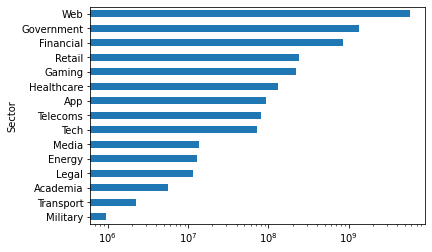

In [9]:
# What is the total number of lost records per sector ? what is the riskiest sector ? 
plt.xscale('log')
df.groupby('Sector')['Records Lost_normalized'].sum().sort_values(ascending=True).plot(kind='barh')

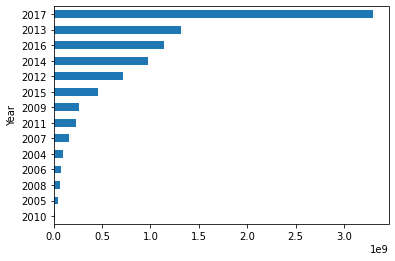

In [10]:
# What is the total number of lost records per year ? what is the worst year ? 
df.groupby('Year')['Records Lost_normalized'].sum().sort_values(ascending=True).plot(kind='barh')

In [27]:
# creating a pivot table with Sector as index and year as column to have a better understanding of our dataset
pivot_1 = pd.pivot_table(df, index='Sector', columns='Year', values='Records Lost_normalized', aggfunc=np.sum, fill_value=0)
# sorting sector according to the number of lost records
idx_pivot_1 = pivot_1.sum(axis=1).sort_values(ascending=False).index
pivot_1 = pivot_1.loc[idx_pivot_1]
pivot_1

Year,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Sector,,,,,,,,,,,,,,
Web,92000000,0,20000000,1600000,18000000,0,3800000,96262000,287763792,1203950000,653936000,350257000,940970658,2107700000
Government,0,0,26500000,31249000,13384500,84460378,903000,9964893,20680000,3560000,5190396,29100000,109886186,1003700000
Financial,0,44225000,2600000,15800000,21500000,135000000,6300000,394083,370000000,150000,103200000,40000,0,144870000
Retail,0,0,0,107637405,97000,0,0,483000,0,0,132260000,500000,1025,2000000
Gaming,0,0,0,0,0,32000000,0,103090755,14000000,58240000,10000000,0,0,0
Healthcare,0,0,0,0,0,4619188,4216476,17003746,543000,4100000,15500000,81181309,4396000,0
App,0,0,0,0,0,0,0,0,0,0,1700000,50000,58700000,32833959
Telecoms,0,0,21000000,0,113000,0,114000,0,8700000,2170000,46200000,0,200000,1940000
Tech,0,0,200000,0,0,573000,0,0,12367232,38275000,1000000,900000,15000000,3000000


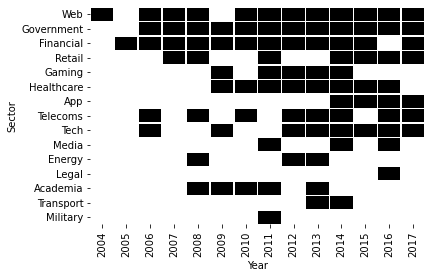

In [43]:
# first way to observe the data: which sectors have been affected and when ?
sns.heatmap(pivot_1, cmap='gist_heat_r', linewidths=0.5, linecolor='white', vmax=1, cbar=False)

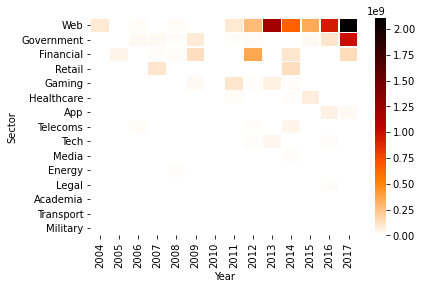

In [40]:
# second way to observe the data: how the different sectors have been affected and when ?
sns.heatmap(pivot_1, cmap='gist_heat_r', linewidths=0.5, linecolor='white')

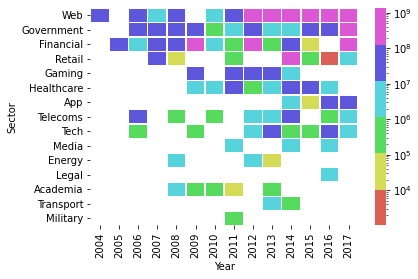

In [149]:
# previously we saw that most of the heatmap is eclipsed by the very high values from the Web sector. One solution to increase readability by using a log scale:

mycolor = sns.color_palette("hls", n_colors=6)
CMAP = LinearSegmentedColormap.from_list('custom_cmap', mycolor, len(mycolor))
sns.heatmap(pivot_1,
            cmap=CMAP,
            linewidths=0.5,
            linecolor='white',
            norm=LogNorm(df['Records Lost_normalized'].min(),df['Records Lost_normalized'].max()),
            vmin=df['Records Lost_normalized'].min(),
            vmax=df['Records Lost_normalized'].max())

In [182]:
# Another way to look at the data
fig = px.scatter(df, x='Sector', y='Year', size='Records Lost_normalized', color='Method of Leak', hover_name='Entity', size_max=60)
fig.show()

In [173]:
# One way to get more info about the incident
HEADERS = {'User-Agent': ua.random, "Accept-Language": "en-US, en;q=0.5"}
def get_meta(url: str):
    try:
        r = requests.get(url, headers=HEADERS)
        if r.status_code == 200:
            url_content = r.content
            info_json = trafilatura.metadata.extract_metadata(url_content)
            return info_json
        else:
            print(f'Status code prohibit access:{r.status_code}')
            return None
    except Exception as e:
        print(f'Error with {url}:\n{e}')

In [216]:
# creating a subset:
df_sub = df.sample(5, random_state=1).copy().reset_index(drop=True)
df_sub

,Entity,Story,Year,Records Lost,Sector,Method of Leak,1st source,Records Lost_normalized,source_name
0,Heartland,"The biggest credit card scam in history, Heart...",2009,1.3e+08,Financial,Hacked,http://www.forbes.com/sites/davelewis/2015/05/...,130000000,forbes.com
1,Bethesda Game Studios,Hacking collective Lulzsec stole account infor...,2011,2e+05,Gaming,Hacked,http://www.pcworld.com/article/231215/lulzsec_...,200000,pcworld.com
2,US Office of Personnel Management (2nd Breach),attackers have targeted the forms submitted by...,2015,21500000,Government,Hacked,http://www.bbc.co.uk/news/world-us-canada-3312...,21500000,bbc.co.uk
3,TIO Networks,The company has not revealed what type of info...,2017,1600000,Financial,Hacked,https://www.bleepingcomputer.com/news/security...,1600000,bleepingcomputer.com
4,Monster.com,A trojan virus stole log-ins that were used to...,2007,1600000,Web,Hacked,http://news.bbc.co.uk/1/hi/6956349.stm,1600000,news.bbc.co.uk


In [212]:
information_sup = {}
for i,r in df_sub.iterrows():
    print(f'Getting more information about {r[0]}: retrieving {r[6]}..')
    meta = get_meta(r[6])
    information_sup[r[0]] = meta
    print(f'{r[0]}: information retrieved.')

Getting more information about Heartland: retrieving http://www.forbes.com/sites/davelewis/2015/05/31/heartland-payment-systems-suffers-data-breach/#155d10312985..
Heartland: information retrieved.
Getting more information about Bethesda Game Studios: retrieving http://www.pcworld.com/article/231215/lulzsec_a_short_history_of_hacking.html..
Bethesda Game Studios: information retrieved.
Getting more information about US Office of Personnel Management (2nd Breach): retrieving http://www.bbc.co.uk/news/world-us-canada-33120405..
US Office of Personnel Management (2nd Breach): information retrieved.
Getting more information about TIO Networks: retrieving https://www.bleepingcomputer.com/news/security/paypal-says-1-6-million-customer-details-stolen-in-breach-at-canadian-subsidiary/..
TIO Networks: information retrieved.
Getting more information about Monster.com: retrieving http://news.bbc.co.uk/1/hi/6956349.stm..
Monster.com: information retrieved.


In [217]:
# Completing dataset:
df_sub['title_retrieved'] = df_sub['Entity'].apply(lambda entity: information_sup.get(entity).get('title'))
df_sub['description_retrieved'] = df_sub['Entity'].apply(lambda entity: information_sup.get(entity).get('description'))

In [218]:
df_sub

,Entity,Story,Year,Records Lost,Sector,Method of Leak,1st source,Records Lost_normalized,source_name,title_retrieved,description_retrieved
0,Heartland,"The biggest credit card scam in history, Heart...",2009,1.3e+08,Financial,Hacked,http://www.forbes.com/sites/davelewis/2015/05/...,130000000,forbes.com,Heartland Payment Systems Suffers Data Breach,Heartland Payment Systems suffered a data brea...
1,Bethesda Game Studios,Hacking collective Lulzsec stole account infor...,2011,2e+05,Gaming,Hacked,http://www.pcworld.com/article/231215/lulzsec_...,200000,pcworld.com,Lulzsec: A Short History of Hacking,The hacker group claims it's disbanding; here ...
2,US Office of Personnel Management (2nd Breach),attackers have targeted the forms submitted by...,2015,21500000,Government,Hacked,http://www.bbc.co.uk/news/world-us-canada-3312...,21500000,bbc.co.uk,US hacking: Military and intelligence data 'ac...,Hackers with suspected links to China appear t...
3,TIO Networks,The company has not revealed what type of info...,2017,1600000,Financial,Hacked,https://www.bleepingcomputer.com/news/security...,1600000,bleepingcomputer.com,PayPal Says 1.6 Million Customer Details Stole...,PayPal says that one of the companies it recen...
4,Monster.com,A trojan virus stole log-ins that were used to...,2007,1600000,Web,Hacked,http://news.bbc.co.uk/1/hi/6956349.stm,1600000,news.bbc.co.uk,BBC NEWS | Technology,US website Monster.com suffers an online attac...


In [ ]:
# We can then perform NLP task on the retrieved text to extract more relevant data